### Load SPM data

In [ ]:
!gdown 15wSHEkeG5ISTX5AzNT8ZFBO6Am54Ylan

Downloading...
From (original): https://drive.google.com/uc?id=15wSHEkeG5ISTX5AzNT8ZFBO6Am54Ylan
From (redirected): https://drive.google.com/uc?id=15wSHEkeG5ISTX5AzNT8ZFBO6Am54Ylan&confirm=t&uuid=912369fd-bfa4-4ea1-9848-8cfd3f3d0779
To: /content/PTO_AC_AE.npz
100% 571M/571M [00:06<00:00, 82.4MB/s]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import cm

In [ ]:
d = np.load('/content/PTO_AC_AE.npz')
print(d.keys())

KeysView(NpzFile '/content/PTO_AC_AE.npz' with keys: scan_rate, v_ac, setpoint, i_gain, data)


In [ ]:
scan_rate, v_ac, setpoint, i_gain, data = d['scan_rate'], d['v_ac'], d['setpoint'], d['i_gain'],  d['data'],

In [ ]:
data.shape

(9, 11, 16, 11, 8, 512)

In [ ]:
v_ac

array([0.05, 0.09, 0.13, 0.17, 0.21, 0.25, 0.29, 0.33, 0.37, 0.41, 0.45])

In [ ]:
np.arange(0.05,0.45, 0.04)

array([0.05, 0.09, 0.13, 0.17, 0.21, 0.25, 0.29, 0.33, 0.37, 0.41])

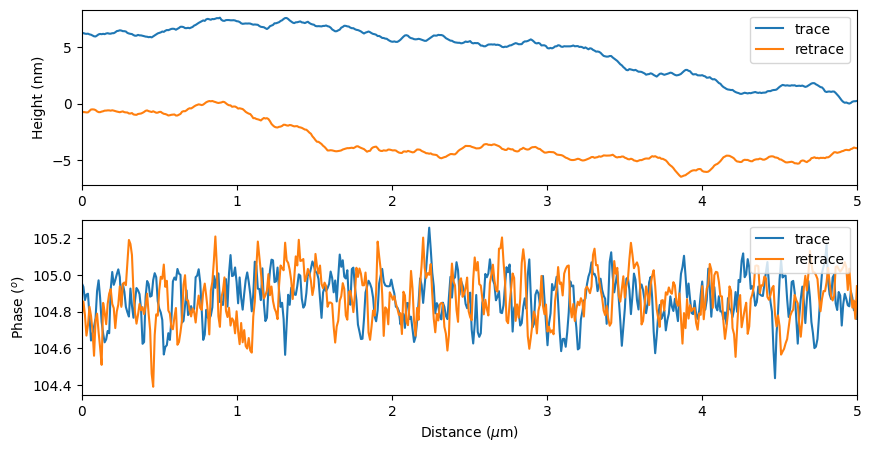

In [ ]:
# Fix scan_rate and I_gain ans proceed measurment using two features
# scan_rate = 1hz
# I_gain = 100

i, j, k, m = [4, 0, 0, 6]

x = np.linspace(0, 5, num=512)
tp = data[i,j,k,m][:2] * 1e9


fig, ax=plt.subplots(2,1,figsize=[10,5])
ax[0].plot(x, tp[0]-np.min(tp[0]), label='trace')
ax[0].plot(x, tp[1]-np.min(tp[0]), label='retrace')
ax[0].set_ylabel('Height (nm)')
ax[0].set_xlim(0, 5)
ax[0].legend(loc='upper right')

tp = data[i,j,k,m][4:6]

ax[1].plot(x, tp[0], label='trace')
ax[1].plot(x, tp[1], label='retrace')
ax[1].set_xlabel('Distance ($\mu$m)')
ax[1].set_ylabel('Phase ($^o$)')
ax[1].set_xlim(0, 5)
ax[1].legend(loc='upper right')

# Contextual Bandits

In [ ]:
#1

class Bandit:
    def __init__(self, n_actions, n_features, reward):
        self.n_actions = n_actions
        self.n_features = n_features
        self.theta = np.random.randn(n_actions, n_features)
        self.reward = reward  # Reward matrix

    def get_reward(self, action, x):
        # Directly use action to index into the reward matrix (assuming action uniquely identifies a tuple (i, j, k, m))
        i = action // (max_j * max_k * max_m)
        jk_m = action % (max_j * max_k * max_m)
        j = jk_m // (max_k * max_m)
        km = jk_m % (max_k * max_m)
        k = km // max_m
        m = km % max_m
        return self.reward[i, j, k, m]

    def get_optimal_reward(self, x):
        # Assuming x translates to multiple potential actions
        possible_rewards = []
        for action in range(self.n_actions):
            i = action // (max_j * max_k * max_m)
            jk_m = action % (max_j * max_k * max_m)
            j = jk_m // (max_k * max_m)
            km = jk_m % (max_k * max_m)
            k = km // max_m
            m = km % max_m
            possible_rewards.append(self.reward[i, j, k, m])
        return np.max(possible_rewards)

## Define reward and features

In [ ]:
# 1
max_i = 9
max_j = 11  # j ranges from 0 to 10
max_k = 16  # k ranges from 0 to 15
max_m = 11

n_actions = max_j * max_k * max_i * max_m
n_features = 4

# Initialize feature array
features = np.zeros((n_actions, n_features))

# Populate the feature array with each combination of j and k along with fixed i and m
index = 0
for i in range(max_i):
    for j in range(max_j):
        for k in range(max_k):
          for m in range(max_m):

            features[index, :] = [i, j, k, m]
            index += 1


reward_matrix = np.zeros([9, 11, 16, 11])  # Your predefined reward matrix

# Populate the reward matrix with your logic
for i in range(9):
    for j in range(11):
        for k in range(16):
            for m in range(11):
                tp = data[i, j, k, m]  # Assuming 'data' is defined elsewhere
                h1, h2 = tp[0] * 1e9, tp[1] * 1e9
                base = np.mean(np.abs(h1 - h2))
                reward_matrix[i, j, k, m] = np.exp(-base)

reward_matrix = np.random.rand(9, 11, 16, 11)  # Random rewards for illustration

# Normalize the rewards
min_reward = np.min(reward_matrix)
max_reward = np.max(reward_matrix)
normalized_rewards = (reward_matrix - min_reward) / (max_reward - min_reward)

# Standardize the rewards
mean_reward = np.mean(reward_matrix)
std_reward = np.std(reward_matrix)
standardized_rewards = (reward_matrix - mean_reward) / std_reward

bandit = Bandit(n_actions, n_features, standardized_rewards)

## Test

In [ ]:
# Example to get a reward for a specific action
action = 5 # Suppose we choose the first action (j=0, k=0)
x = features[action]  # Features for the chosen action

# Get the reward for the selected action
reward_ex = bandit.get_reward(action, x)
print(f"Reward for action {action}:", reward_ex)

# Calculate the optimal reward for the same feature set
optimal_reward_ex = bandit.get_optimal_reward(x)
print("Optimal Reward for given features:", optimal_reward_ex)

Reward for action 5: -1.5061151330927467
Optimal Reward for given features: 1.7199548130302658


Plot some random rewards

In [ ]:
# Compute rewards for each action
rewardsss = [bandit.get_reward(i, features[i]) for i in range(n_actions)]

# Selecting a subset for plotting
indices_to_plot = range(0, n_actions, 100)  # Every 10th index
selected_features = features[indices_to_plot]
selected_rewards = [rewardsss[i] for i in indices_to_plot]

<ipython-input-14-934958f7511e>:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


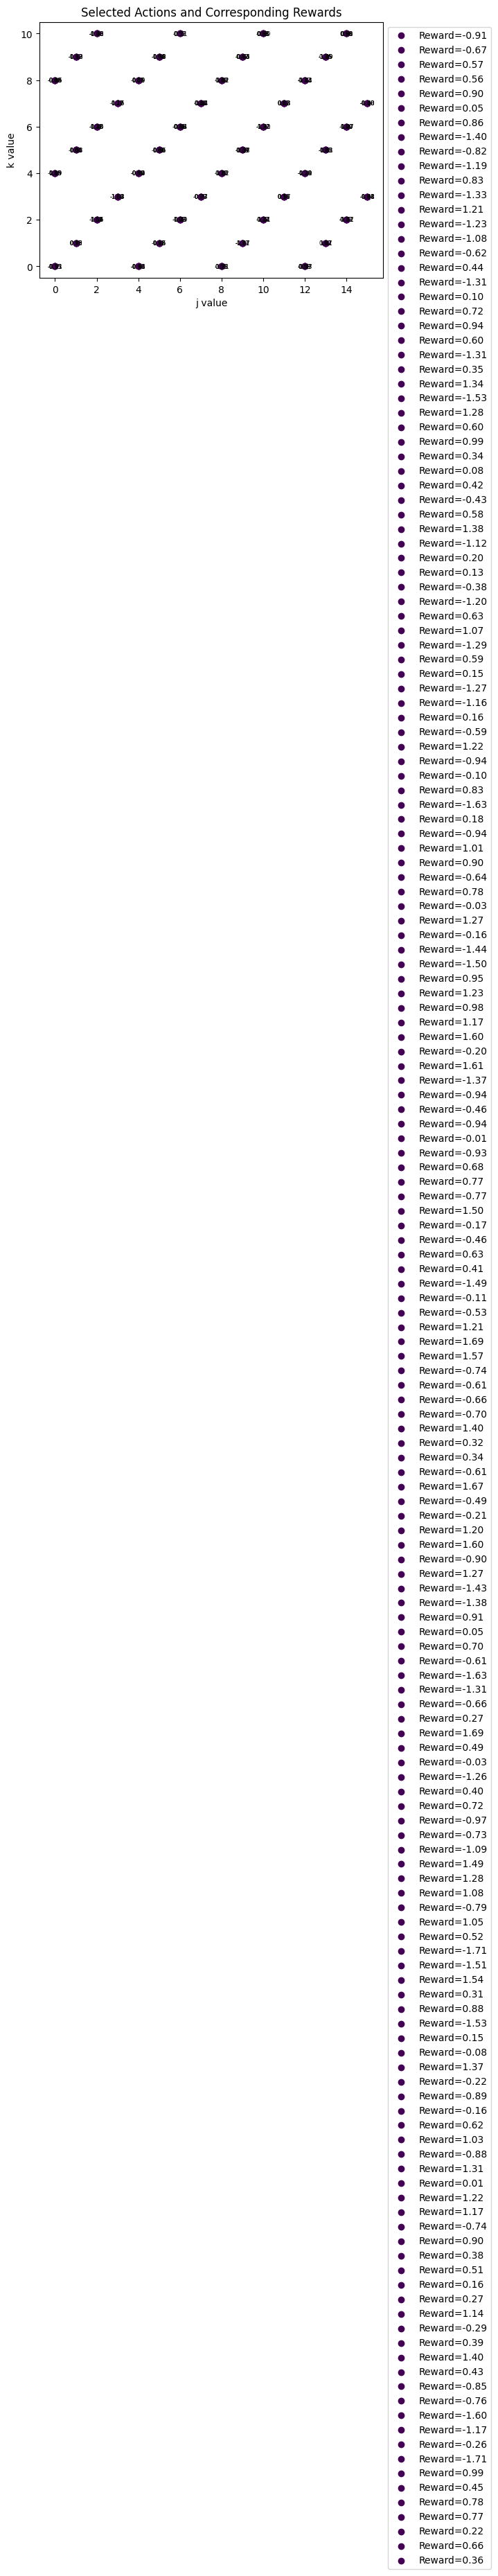

In [ ]:
for (f, reward) in zip(selected_features, selected_rewards):
    j, k = int(f[2]), int(f[3])
    # plt.scatter(j, k, s=np.abs(reward) * 20, label=f'j={j}, k={k}, Reward={reward:.2f}')
    plt.scatter(j, k, c=[reward] ,  label=f'Reward={reward:.2f}')
    plt.text(j, k, f'{reward:.2f}', color='black', ha='center', va='center', fontsize=6)
plt.xlabel('j value')
plt.ylabel('k value')
plt.title('Selected Actions and Corresponding Rewards')
# plt.colorbar(label='Reward Magnitude')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Neural network model

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_features):
        super(NeuralNetwork, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, 1))
    def forward(self, x):
        return self.layer(x)

class NeuralBandit:
    def __init__(self, n_actions, n_features, learning_rate, epsilon):
        self.n_actions = n_actions
        self.n_features = n_features
        self.learning_rate = learning_rate
        self.epsilon = epsilon  # Initial epsilon for the epsilon-greedy policy
        self.epsilon_min = 0.01  # Minimum epsilon value
        self.epsilon_decay = 0.995  # Decay rate for epsilon

        # Initialize the neural network model for each action
        self.models = [NeuralNetwork(n_features) for _ in range(n_actions)]
        self.optimizers = [optim.Adam(model.parameters(), lr=0.05) for model in self.models]
        self.criterion = nn.MSELoss()

    def predict(self, context):
        context_tensor = torch.tensor(context, dtype=torch.float32)
        with torch.no_grad():
            return torch.cat([model(context_tensor).reshape(1) for model in self.models])

    def select_action(self, context):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_actions)
        else:
            pred_rewards = self.predict(context)
            action = torch.argmax(pred_rewards).item()
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)  # Decay epsilon
        return action

    def update(self, action, context, reward):
        self.optimizers[action].zero_grad()
        context_tensor = torch.tensor(context, dtype=torch.float32)
        reward_tensor = torch.tensor(reward, dtype=torch.float32)
        pred_reward = self.models[action](context_tensor)
        loss = self.criterion(pred_reward, reward_tensor)
        loss.backward()
        self.optimizers[action].step()

# Evaluation

In [ ]:
n_actions = max_j * max_k * max_i * max_m
n_features = 4
bandit = Bandit(n_actions, n_features, reward_matrix)
neural_agent = NeuralBandit(n_actions, n_features, learning_rate=0.1, epsilon=0.1)

n_steps = 1000
cumulative_rewards = np.zeros(n_steps)
cumulative_regrets = np.zeros(n_steps)

for t in range(n_steps):
    x = np.random.randn(n_features)
    action = neural_agent.select_action([x])
    reward = bandit.get_reward(action, x)
    optimal_reward = bandit.get_optimal_reward(x)
    neural_agent.update(action, x, reward)

    cumulative_rewards[t] = reward if t == 0 else cumulative_rewards[t-1] + reward
    cumulative_regrets[t] = optimal_reward - reward if t == 0 else cumulative_regrets[t-1] + (optimal_reward - reward)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
<ipython-input-15-fad97fc8ef80>:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  context_tensor = torch.tensor(context, dtype=torch.float32)


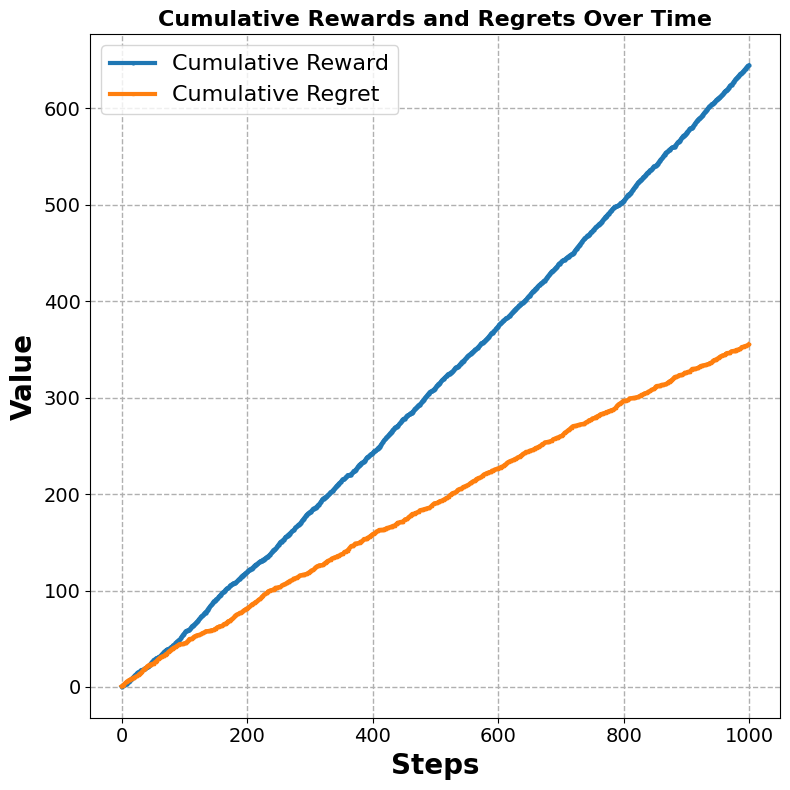

In [ ]:
color_palette = ['#1f77b4', '#ff7f0e']  # Blue for reward, Orange for regret

# Start plotting
plt.figure(figsize=(8, 8))  # Set a suitable figure size

# Plot both cumulative rewards and regrets on the same plot
plt.plot(cumulative_rewards, label='Cumulative Reward', color=color_palette[0], linewidth=3, marker='o', markersize=2)
plt.plot(cumulative_regrets, label='Cumulative Regret', color=color_palette[1], linewidth=3, marker='s', markersize=2)

# Adding titles and labels
plt.title('Cumulative Rewards and Regrets Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Steps', fontsize=20, fontweight='bold' )
plt.ylabel('Value', fontsize=20,  fontweight='bold')
# Adjusting tick label sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Adding gridlines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=1)

# Adding a legend to differentiate between the plotted lines
plt.legend(fontsize=16)

# Adjust layout to make sure everything fits well
plt.tight_layout()

# Display the plot
plt.show()

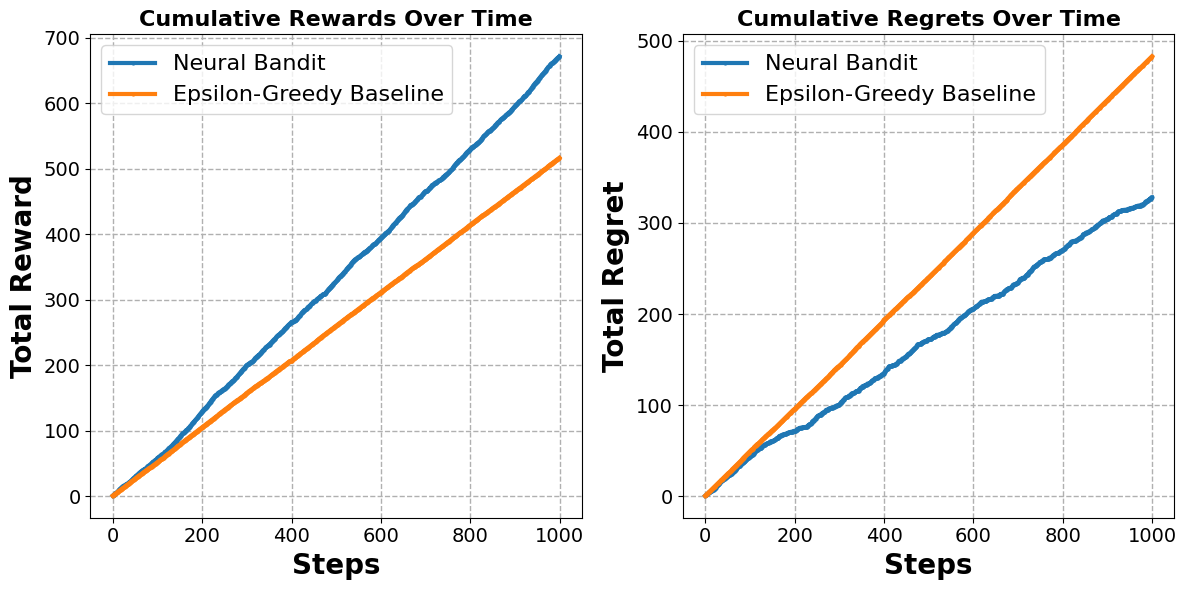

In [ ]:
class EpsilonGreedyAgent:
    def __init__(self, n_actions, epsilon):
        self.n_actions = n_actions
        self.epsilon = epsilon

        # Initialize Q-values for each action
        self.q_values = np.zeros(n_actions)

    def select_action(self):
        if np.random.random() < self.epsilon:
            # Exploration: choose a random action
            return np.random.randint(self.n_actions)
        else:
            # Exploitation: choose the action with the highest Q-value
            return np.argmax(self.q_values)

    def update(self, action, reward):
        # Update Q-value for the selected action using simple average
        self.q_values[action] += (reward - self.q_values[action]) / (t + 1)  # Incremental update


# Initialize epsilon-greedy agent for baseline comparison
baseline_agent = EpsilonGreedyAgent(n_actions, epsilon=0.1)

# Simulation loop with baseline agent
baseline_cumulative_rewards = np.zeros(n_steps)
baseline_cumulative_regrets = np.zeros(n_steps)

for t in range(n_steps):
    x = np.random.randn(n_features)  # Generate some features
    action = baseline_agent.select_action()  # Select action using epsilon-greedy policy
    reward = bandit.get_reward(action, x)  # Get the reward for the selected action
    optimal_reward = bandit.get_optimal_reward(x)  # Get the optimal reward for the current context
    baseline_agent.update(action, reward)  # Update the Q-values

    # Track cumulative rewards and regrets for baseline agent
    baseline_cumulative_rewards[t] = reward if t == 0 else baseline_cumulative_rewards[t-1] + reward
    baseline_cumulative_regrets[t] = optimal_reward - reward if t == 0 else baseline_cumulative_regrets[t-1] + (optimal_reward - reward)

# Plot cumulative rewards and regrets for both agents
plt.figure(figsize=(12, 6))

# Plot cumulative rewards
plt.subplot(121)
plt.plot(cumulative_rewards, label='Neural Bandit', linewidth=3, marker='o', markersize=2)
plt.plot(baseline_cumulative_rewards, label='Epsilon-Greedy Baseline', linewidth=3, marker='o', markersize=2)
plt.title('Cumulative Rewards Over Time', fontsize=16,  fontweight='bold')
plt.xlabel('Steps', fontsize=20,  fontweight='bold')
plt.ylabel('Total Reward', fontsize=20,  fontweight='bold')
# Adjusting tick label sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Adding gridlines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=1)
plt.legend(fontsize=16)

# Plot cumulative regrets
plt.subplot(122)
plt.plot(cumulative_regrets, label='Neural Bandit', linewidth=3, marker='o', markersize=2)
plt.plot(baseline_cumulative_regrets, label='Epsilon-Greedy Baseline', linewidth=3, marker='o', markersize=2)
plt.title('Cumulative Regrets Over Time', fontsize=16,  fontweight='bold')
plt.xlabel('Steps',  fontsize=20,  fontweight='bold')
plt.ylabel('Total Regret',   fontsize=20,  fontweight='bold')
# Adjusting tick label sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Adding gridlines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=1)
plt.legend(fontsize=16)

plt.tight_layout()
plt.show()


## Reward visualization

In [ ]:
# Compute rewards for each action
rewards = [bandit.get_reward(i, features[i]) for i in range(n_actions)]

num_samples = 50  # Number of random samples to select
indices_to_plot = np.random.choice(range(n_actions), num_samples, replace=False)  # Randomly select indices
selected_features = features[indices_to_plot]
selected_rewards = [rewards[i] for i in indices_to_plot]

<ipython-input-19-9eb907221946>:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


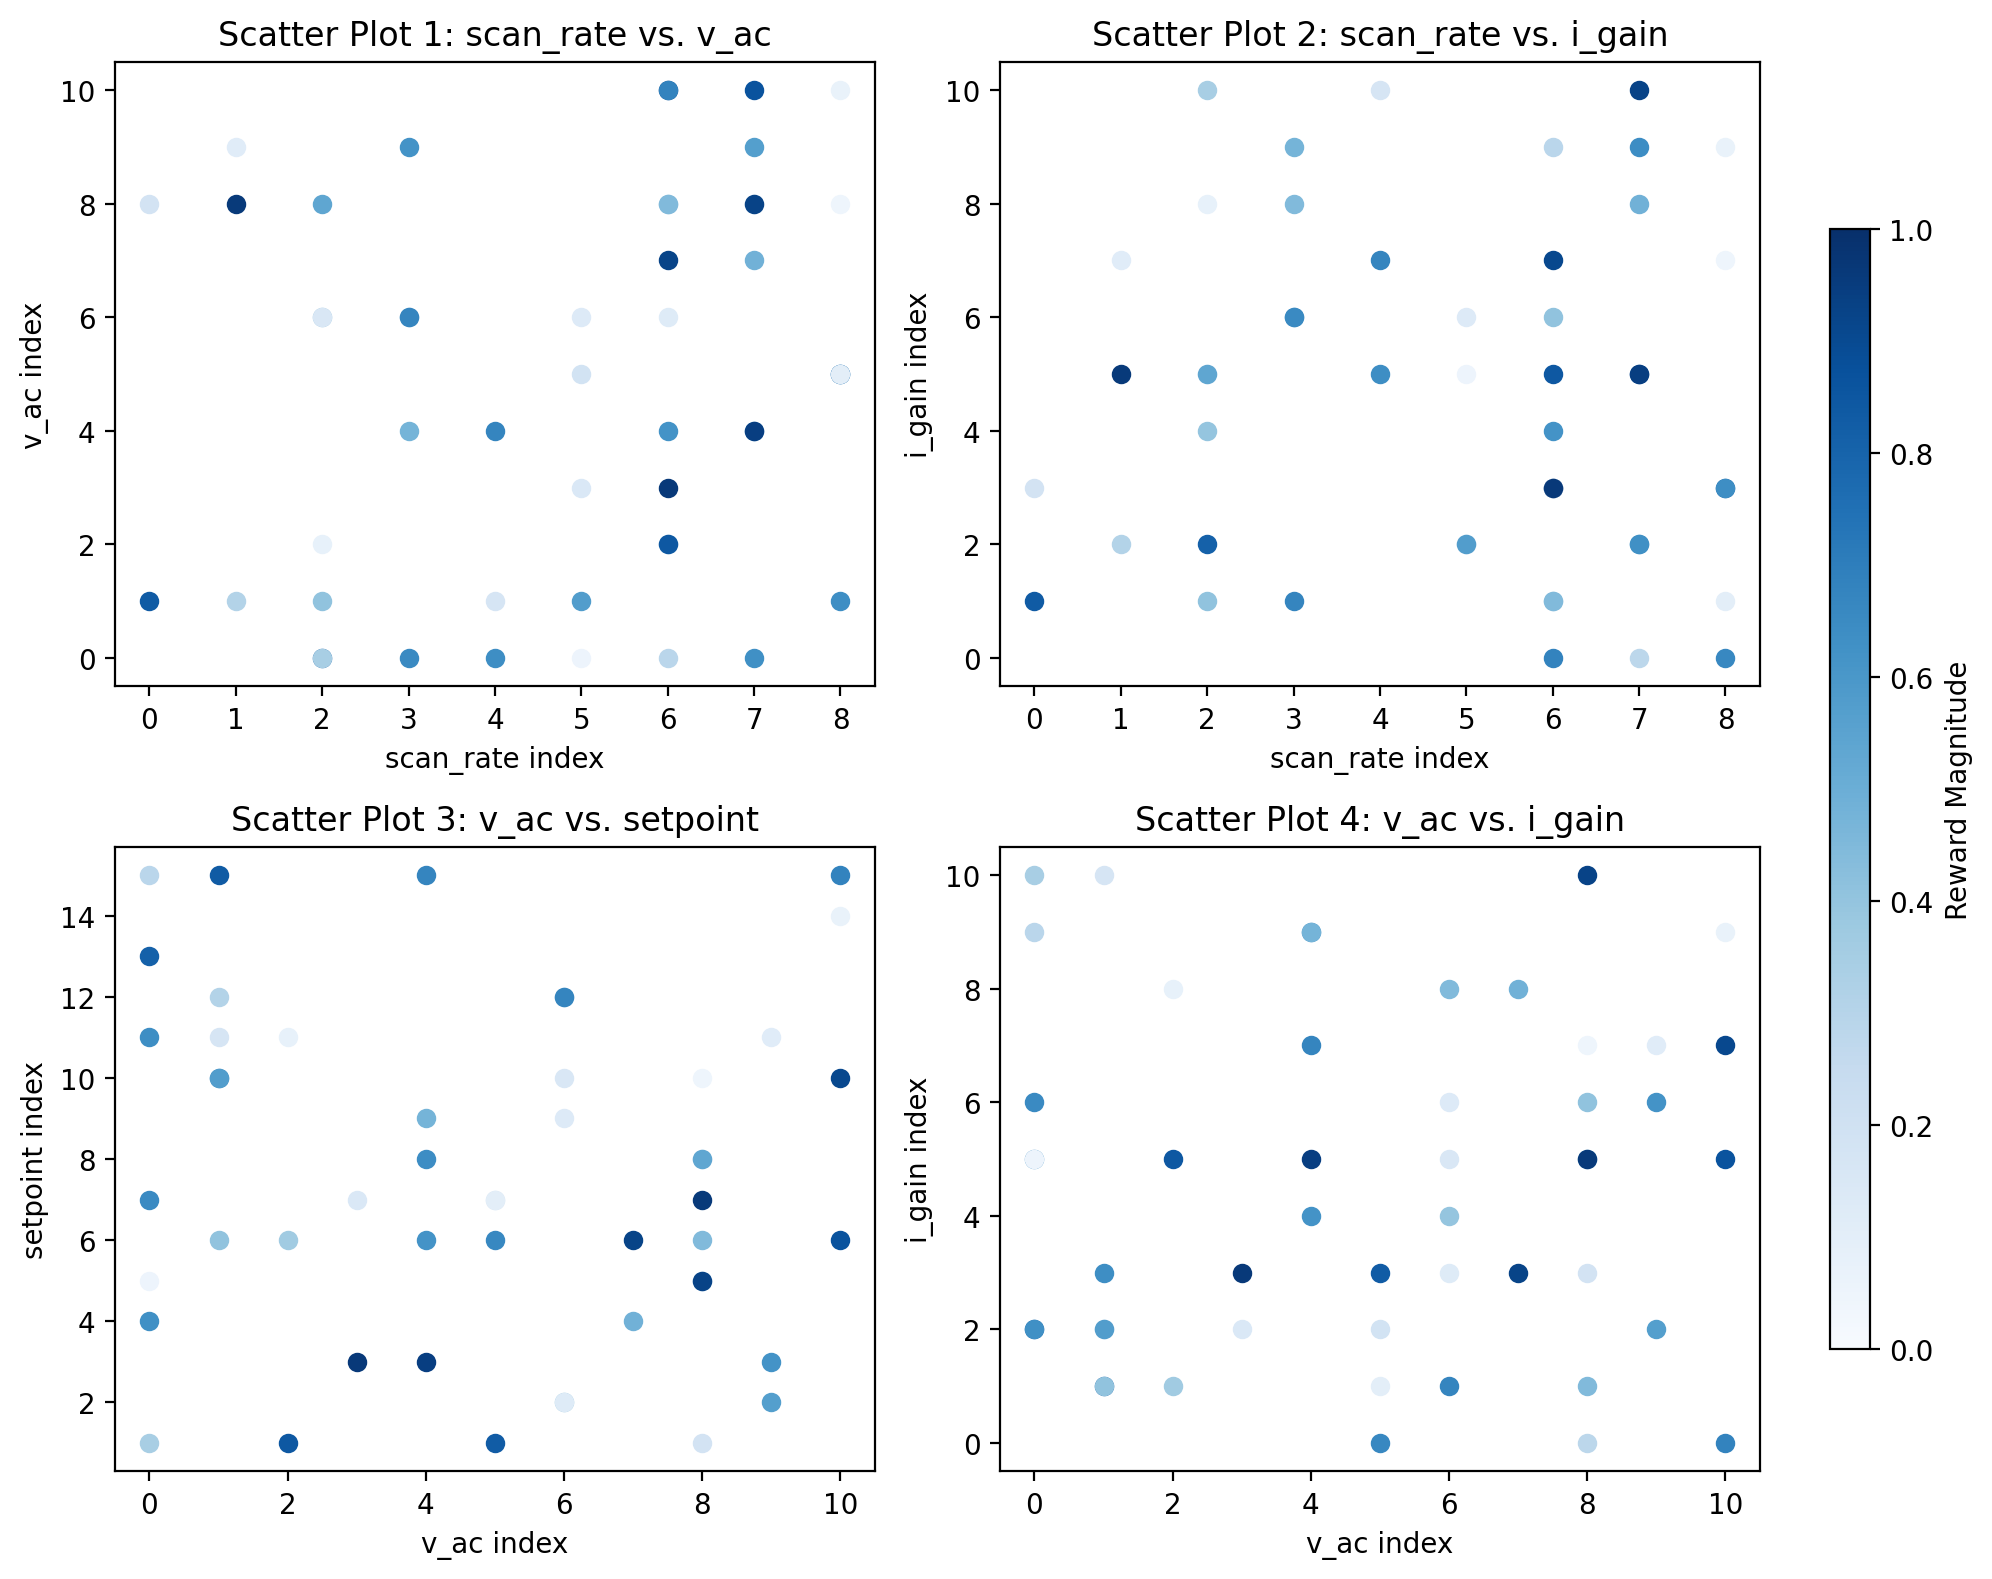

In [ ]:
# Assuming selected_features and selected_rewards are defined
cmap = cm.Blues

# Start plotting
plt.figure(figsize=(10, 8), dpi=200)  # Increased width for colorbar space

# Plot 1: Scatter plot for features[0] and features[1]
ax1 = plt.subplot(2, 2, 1)
for (f, reward) in zip(selected_features, selected_rewards):
    j, k = int(f[0]), int(f[1])
    sc = ax1.scatter(j, k, c=[reward], cmap=cmap, vmin=0, vmax=1)
    #ax1.text(j, k, f'{reward:.2f}', color='black', ha='center', va='center', fontsize=6)
ax1.set_xlabel('scan_rate index')
ax1.set_ylabel('v_ac index')
ax1.set_title('Scatter Plot 1: scan_rate vs. v_ac')
# ax1.set_xticks(scan_rate )
#ax1.set_yticks(v_ac)

# Plot 2: Scatter plot for features[0] and features[3]
ax2 = plt.subplot(2, 2, 2)
for (f, reward) in zip(selected_features, selected_rewards):
    i, m = int(f[0]), int(f[3])
    ax2.scatter(i, m, c=[reward], cmap=cmap, vmin=0, vmax=1)
    #ax2.text(i, m, f'{reward:.2f}', color='black', ha='center', va='center', fontsize=6)
ax2.set_xlabel('scan_rate index')
ax2.set_ylabel('i_gain index')
ax2.set_title('Scatter Plot 2: scan_rate vs. i_gain')

# Plot 3: Scatter plot for features[1] and features[2]
ax3 = plt.subplot(2, 2, 3)
for (f, reward) in zip(selected_features, selected_rewards):
    j, m = int(f[1]), int(f[2])
    ax3.scatter(j, m, c=[reward], cmap=cmap, vmin=0, vmax=1)
    #ax3.text(j, m, f'{reward:.2f}', color='black', ha='center', va='center', fontsize=6)
ax3.set_xlabel('v_ac index')
ax3.set_ylabel('setpoint index')
ax3.set_title('Scatter Plot 3: v_ac vs. setpoint')

# Plot 4: Scatter plot for features[1] and features[3]
ax4 = plt.subplot(2, 2, 4)
for (f, reward) in zip(selected_features, selected_rewards):
    j, m = int(f[1]), int(f[3])
    ax4.scatter(j, m, c=[reward], cmap=cmap, vmin=0, vmax=1)
    #ax4.text(j, m, f'{reward:.2f}', color='black', ha='center', va='center', fontsize=6)
ax4.set_xlabel('v_ac index')
ax4.set_ylabel('i_gain index')
ax4.set_title('Scatter Plot 4: v_ac vs. i_gain')

# Adding a colorbar to the right of the plots
fig = plt.gcf()
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # left, bottom, width, height (in normalized figure coordinates)
fig.colorbar(sc, cax=cbar_ax, orientation='vertical', label='Reward Magnitude')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()
